## CAPSTONE PROJECT - REGRESSION

### IMPORT PACKAGES

In [1]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### LOAD DATASET

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/DatabaseColab/CapstoneJDS'
df_train = pd.read_csv(os.path.join(path, "Housing_Rental_Prices_train.csv"), encoding='utf-8')
df_test = pd.read_csv(os.path.join(path, "Housing_Rental_Prices_test.csv"), encoding='utf-8')

In [4]:
df_train.head()

,bedroom,bathrooms,area,furnishing,avalable_for,address,floor_number,facing,floor_type,gate_community,corner_pro,parking,wheelchairadption,petfacility,aggDur,noticeDur,lightbill,powerbackup,propertyage,no_room,pooja_room,study_room,others,servant_room,store_room,maintenance_amt,brok_amt,deposit_amt,mnt_amt,rent
0,2,2,1050.0,Unfurnished,All,"Sadguru hights, Pingale Wasti, , Pune, Maharas...",5,West,Marble,Yes,No,0,None,None,11,2,0,2,5 to 10 Year Old,1,0,0,0,0,0,0,0,3,0.0,20000.0
1,2,2,760.0,Unfurnished,All,"Manav Silver Springs, Wagholi, , Pune, Maharas...",5,East,Vitrified,Yes,Yes,2,None,None,11,1,0,2,1 to 5 Year Old,1,0,0,0,0,0,0,0,40000,0.0,14000.0
2,3,3,0.0,Semifurnished,All,"Saarrthi Souvenir, Mahalunge, , Pune, Maharashtra",1,South-West,Vitrified,Yes,No,1,None,None,11,1,0,2,1 to 5 Year Old,0,0,0,1,0,0,Maintenance 1/ (/ month,23000,60000,1.0,22999.0
3,1,1,628.0,Furnished,Family Only,"Dhan Residency, Wanowrie, , Pune, Maharashtra",3,East,Mosaic,Yes,No,1,None,None,11,1,0,0,10+ Year Old,1,0,0,0,0,0,0,0,40000,0.0,13000.0
4,2,2,668.0,Semifurnished,"Family , Bachelors (Men Only)","Saptsiddhi Savali Homes, Uruli Devachi, , Pune...",6,South,Polished concrete,Yes,Yes,1,None,None,12,1,1,1,1 to 5 Year Old,1,0,0,0,0,0,0,0,20,0.0,7500.0


### PROBLEM STATEMENT

<b>1. Berapa harga yang tepat untuk harga sewa rumah berdasarkan fasilitas-fasilitas yang tersedia</b>

Dari data didapatkan :
<br>X = bedroom, bathroom, furnishing, wheelchairadption, petfacility
<br>Y = rent

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10884 entries, 0 to 10883
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedroom            10884 non-null  int64  
 1   bathrooms          10884 non-null  int64  
 2   area               10884 non-null  float64
 3   furnishing         10884 non-null  object 
 4   avalable_for       10884 non-null  object 
 5   address            10884 non-null  object 
 6   floor_number       10884 non-null  int64  
 7   facing             10884 non-null  object 
 8   floor_type         10884 non-null  object 
 9   gate_community     10884 non-null  object 
 10  corner_pro         10884 non-null  object 
 11  parking            10884 non-null  int64  
 12  wheelchairadption  10884 non-null  object 
 13  petfacility        10884 non-null  object 
 14  aggDur             10884 non-null  int64  
 15  noticeDur          10884 non-null  int64  
 16  lightbill          108

Tidak ditemukan missing value maupun NA

### EDA

In [57]:
df_train_true = df_train[["furnishing", "rent"]]
df_train_true.head()

,furnishing,rent
0,Unfurnished,20000.0
1,Unfurnished,14000.0
2,Semifurnished,22999.0
3,Furnished,13000.0
4,Semifurnished,7500.0


In [7]:
df_train_true.describe()

,rent
count,1.088400e+04
mean,2.855947e+04
std,1.183249e+06
min,1.600000e+03
25%,1.050000e+04
50%,1.500000e+04
75%,2.100000e+04
max,1.234568e+08


Rumah dengan 2, 4, dan 5 kamar memiliki harga sewa yang lebih tinggi dari rumah dengan jumlah kamar lain

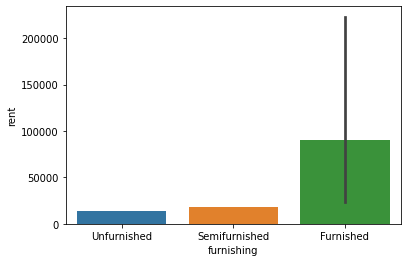

In [59]:
sns.barplot(x=df_train_true.furnishing, y=df_train_true.rent)

Rumah yang sudah memiliki furniture memiliki harga sewa yang jauh lebih tinggi, harga sewa rumah yang semifurnished kurang lebih sama dengan rumah yang unfurnished

### DATA PRE-PROCESSING

In [61]:
kategori = ["furnishing"]
df_cat = df_train_true[kategori]
df_cat.head()

,furnishing
0,Unfurnished
1,Unfurnished
2,Semifurnished
3,Furnished
4,Semifurnished


In [58]:
df_train_true['furnishing'] = df_train_true['furnishing'].replace(['Unfurnishe'],'Unfurnished')
# Mengganti semua value Unfurnishe menjadi Unfurnished

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [62]:
status = pd.get_dummies(df_train_true['furnishing'])
status.head()

,Furnished,Semifurnished,Unfurnished
0,0,0,1
1,0,0,1
2,0,1,0
3,1,0,0
4,0,1,0


Data kategorik akan diubah menjadi numerik untuk analisis Regresi

In [63]:
status = pd.get_dummies(df_train_true['furnishing'])
df_train_true = pd.concat([df_train_true, status], axis = 1)

In [64]:
df_train_true.drop(['furnishing'], axis = 1, inplace = True)

In [65]:
df_train_true.drop(['Furnished'], axis = 1, inplace = True)

In [15]:
encoded_data = LabelEncoder()

for feature in kategori:
        if feature in df_train_true.columns.values:
            df_train_true[feature] = encoded_data.fit_transform(df_train_true[feature])

In [66]:
df_train_true.head()

,rent,Semifurnished,Unfurnished
0,20000.0,0,1
1,14000.0,0,1
2,22999.0,1,0
3,13000.0,0,0
4,7500.0,1,0


### FEATURE ENGINEERING

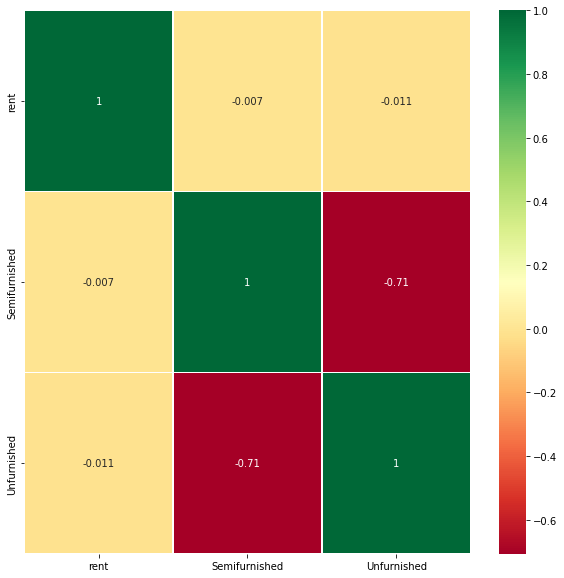

In [67]:
# Cek korelasi

sns.heatmap(df_train_true.corr(),linewidths=.5,annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

Nilai tertinggi berada diatas 0.3, data diasumsikan berkorelasi kuat

In [18]:
df_train_true.head()

,rent,Semifurnished,Unfurnished
0,20000.0,0,1
1,14000.0,0,1
2,22999.0,1,0
3,13000.0,0,0
4,7500.0,1,0


### MODELING

In [19]:
#Split Test Train

X = df_train_true.drop('rent', axis=1)
y = df_train_true['rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X Train : ", len(X_train))
print("y Train : ", len(y_train))
print("X Test : ", len(X_test))
print("t Test : ", len(y_test))

X Train :  7618
y Train :  7618
X Test :  3266
t Test :  3266


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [21]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [22]:
print(lin_reg.intercept_)

33423.76585866763


In [23]:
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
Semifurnished,-48573.897264
Unfurnished,-51481.872693


### EVALUATION

In [24]:
pred = lin_reg.predict(X_test)

In [25]:
dataprediction = pd.DataFrame({'True Values': y_test, 'Predicted Values': pred})
dataprediction = pd.DataFrame.from_dict(dataprediction)

Text(0, 0.5, 'Predicted Values')

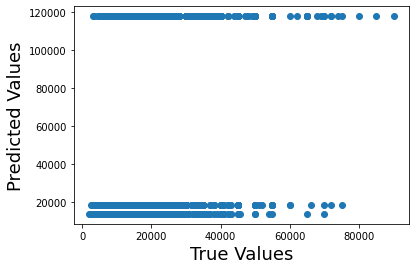

In [26]:
plt.scatter(y_test, pred)
plt.xlabel('True Values', fontsize = 18)  
plt.ylabel('Predicted Values', fontsize = 18)  

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Errors')

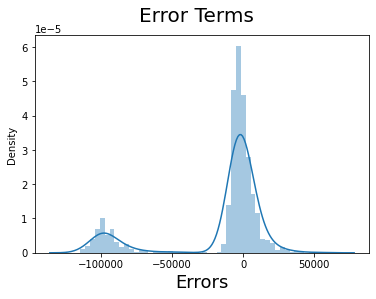

In [27]:
sns.distplot((y_test-pred),bins=50)
plt.suptitle('Error Terms', fontsize = 20)               
plt.xlabel('Errors', fontsize = 18)  

In [28]:
Input = sm.add_constant(X)
SimpleModel = sm.OLS(y,Input, missing='drop')
results = SimpleModel.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.047
Date:                Tue, 02 Nov 2021   Prob (F-statistic):             0.0476
Time:                        03:15:02   Log-Likelihood:            -1.6764e+05
No. Observations:               10884   AIC:                         3.353e+05
Df Residuals:                   10881   BIC:                         3.353e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          9.004e+04   2.74e+04      3.283

In [29]:
#Uji Kelayakan Model

f_value = results.fvalue
print("f-test score : ", f_value)

p_value = results.f_pvalue
print("P-value : ", p_value)

if p_value < 0.05:
  print("Tolak H0")
else:
  print("Terima H0")

f-test score :  3.046746150195135
P-value :  0.0475538102803648
Tolak H0


In [30]:
#Uji Residual

from scipy.stats import shapiro
df_train["residual"] = y_test - pred
stat_e, pval_e = shapiro(df_train["residual"])

print(f"p value uji normalitas data Residual = {pval_e}")

p value uji normalitas data Residual = 1.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [31]:
corr = df_train_true[["Semifurnished", "Unfurnished", "rent"]].corr()
print('Pearson correlation coefficient matrix of each variables:\n', corr)

Pearson correlation coefficient matrix of each variables:
                Semifurnished  Unfurnished      rent
Semifurnished       1.000000    -0.707419 -0.007024
Unfurnished        -0.707419     1.000000 -0.010998
rent               -0.007024    -0.010998  1.000000


In [32]:
from statsmodels.stats.stattools import durbin_watson

durbinWatson = durbin_watson(df_train['residual'])

print('Durbin-Watson:', durbinWatson)
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')

Durbin-Watson: nan
Little to no autocorrelation 

Assumption satisfied


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


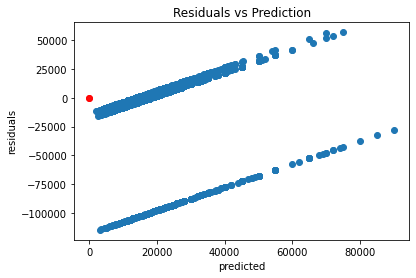

In [33]:
asm_homosk = plt.scatter(df_train["rent"], df_train["residual"])
plt.xlabel('predicted')
plt.ylabel('residuals')
asm_homosk = sns.regplot([2,5],[0,0],color='red')
asm_homosk = plt.title('Residuals vs Prediction')

In [34]:
olsmod = sm.OLS(df_train_true['rent'], X).fit()
print('R2 score:', olsmod.rsquared)

R2 score: 0.00015207886197421416


### LOAD AND PREDICT NEW DATA

In [35]:
df_test_true = df_test[["furnishing", "rent"]]
df_test_true.head()

,furnishing,rent
0,Semifurnished,18500.0
1,Semifurnished,21000.0
2,Semifurnished,12000.0
3,Furnished,24000.0
4,Semifurnished,13500.0


In [36]:
df_test_true['furnishing'] = df_test_true['furnishing'].replace(['Unfurnishe'],'Unfurnished')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
statusnew = pd.get_dummies(df_test_true['furnishing'], drop_first=True)
statusnew.head()

,Semifurnished,Unfurnished
0,1,0
1,1,0
2,1,0
3,0,0
4,1,0


In [38]:
df_test_true = pd.concat([df_test_true, statusnew], axis = 1)
df_test_true.drop(['furnishing'], axis = 1, inplace = True)

In [39]:
df_test_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5361 entries, 0 to 5360
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rent           5361 non-null   float64
 1   Semifurnished  5361 non-null   uint8  
 2   Unfurnished    5361 non-null   uint8  
dtypes: float64(1), uint8(2)
memory usage: 52.5 KB


In [40]:
#Split Test Train

X = df_test_true.drop('rent', axis=1)
y = df_test_true['rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X Train : ", len(X_train))
print("y Train : ", len(y_train))
print("X Test : ", len(X_test))
print("t Test : ", len(y_test))

X Train :  3752
y Train :  3752
X Test :  1609
t Test :  1609


In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [42]:
lin_reg_new = LinearRegression(normalize=True)
lin_reg_new.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [43]:
print(lin_reg_new.intercept_)

17005.34230909115


In [44]:
olsmod = sm.OLS(df_test_true['rent'], X).fit()
print('R2 score:', olsmod.rsquared)

R2 score: 0.555456075570916


In [45]:
coeff_df_new = pd.DataFrame(lin_reg_new.coef_, X.columns, columns=['Coefficient'])
coeff_df_new

,Coefficient
Semifurnished,-2184.289773
Unfurnished,-4206.179830


### KESIMPULAN/SARAN

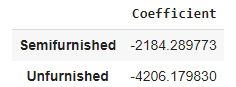

Terjadi penurunan harga sewa yang signifikan terhadap rumah dengan furnitur yang kurang lengkap dan tidak ada furnitur sama sekali, sehingga akan lebih baik jika rumah yang dijual memiliki furnitur yang lengkap untuk mendapatkan harga sewa yang bisa memberikan keuntungan lebih besar.

Model ini hanya memprediksikan 55% dari faktor-faktor yang mempengaruhi harga sewa rumah sehingga dibutuhkan evaluasi lebih lanjut untuk mendapatkan hasil yang lebih baik